In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dense
from keras.optimizers import Adam
import keras
import numpy as np
import random
from keras.preprocessing import image
print(keras.__version__)
import bcolz

DATA_PATH='/home/sravya/data/muse/'
SYNTH_HOME = DATA_PATH+'SynthText/SynthText/'
SYNTH_HOME_NEW = '/home/sravya/data/muse/SynthText/SynthText_split/'

IMAGE_SIZE = (600, 419, 3)
IMAGENET_SIZE = (224,224)

Using Theano backend.
1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/sravya/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.0-64/cuda_ndarray', '-I/home/sravya/anaconda3/lib/python3.6/site-packages/theano/sandbox/cuda', '-I/home/sravya/anaconda3/lib/python3.6/site-packages/numpy/core/include', '-I/home/sravya/anaconda3/include/python3.6m', '-I/home/sravya/anaconda3/lib/python3.6/site-packages/theano/gof', '-L/home/sravya/anaconda3/lib', '-o', '/home/sravya/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.0-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-lcublas', '-lpython3.6m', '-lcudart']
2.0.8


In [5]:
imnames = np.load(SYNTH_HOME + 'processed/imnames.npy')
wordBB = np.load(SYNTH_HOME + 'processed/wordBB.npy')
text = np.load(SYNTH_HOME + 'processed/text.npy')

# Split into train, valid, test

In [6]:
len(imnames), len(wordBB), len(text)

(305600, 305600, 305600)

In [7]:
indices = np.arange(len(imnames))
random.shuffle(indices)
size = len(indices)
train_indices = indices[:int(size*0.7)]
valid_indices = indices[int(size*0.7):int(size*0.9)]
test_indices = indices[int(size*0.9):size]

In [13]:
len(train_indices), len(valid_indices), len(test_indices)

(213920, 61120, 30560)

In [21]:
assert size == len(train_indices) + len(valid_indices) + len(test_indices)

In [28]:
import os
def move_to_split(split,indices):
    skipped_files = []
    for filename in imnames[indices]:
        try:
            os.renames(SYNTH_HOME+ filename[0], SYNTH_HOME_NEW + split + '/' + filename[0])
        except FileNotFoundError:
            print(SYNTH_HOME+ filename[0])
            skipped_files = skipped_files + SYNTH_HOME+ filename[0]
    return skipped_files

In [29]:
assert len(move_to_split('train',train_indices)) == 0
assert len(move_to_split('valid',valid_indices)) == 0
assert len(move_to_split('test',test_indices)) == 0

# Create VGG model and extract conv features for later use

In [4]:
train_size = 213920
valid_size = 61120
test_size = 30560
vgg16 = keras.applications.vgg16.VGG16(include_top=False)

gen=image.ImageDataGenerator()
train = gen.flow_from_directory(SYNTH_HOME_NEW + 'train',
                                target_size=IMAGENET_SIZE, color_mode='rgb', class_mode=None)

valid = gen.flow_from_directory(SYNTH_HOME_NEW + 'valid',
                                target_size=IMAGENET_SIZE, color_mode='rgb', class_mode=None)

test = gen.flow_from_directory(SYNTH_HOME_NEW + 'test',
                               target_size=IMAGENET_SIZE, color_mode='rgb', class_mode=None)

train_feat = vgg16.predict_generator(train, steps=train_size/32)
bcolz.carray(train_feat, rootdir=SYNTH_HOME_NEW + 'feats/train_feat.dat', mode='w')

valid_feat = vgg16.predict_generator(valid, steps=valid_size/32)
bcolz.carray(valid_feat, rootdir=SYNTH_HOME_NEW + 'feats/valid_feat.dat', mode='w')

test_feat = vgg16.predict_generator(test, steps=test_size/32)
bcolz.carray(test_feat, rootdir=SYNTH_HOME_NEW + 'feats/test_feat.dat', mode='w')

Found 213920 images belonging to 200 classes.
Found 61120 images belonging to 200 classes.
Found 30560 images belonging to 200 classes.


KeyboardInterrupt: 

In [43]:
train_feat = bcolz.open(SYNTH_HOME_NEW + 'feats/train_feat.dat')[:]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
valid_feat = bcolz.open(SYNTH_HOME_NEW + 'feats/valid_feat.dat')[:]

In [ ]:
test_feat = bcolz.open(SYNTH_HOME_NEW + 'feats/test_feat.dat')[:]

In [ ]:
#TODO: Break the data into train, valid and test
#TODO: Extract conv feature from vgg
#TODO: 

In [7]:
vgg_out_shape = vgg16.output_shape

In [8]:
#anchors = 5
sizes = 2
ratios = 6

In [10]:
inp = Input(shape=vgg_out_shape[1:])
c1 = Conv2D(64, (3,3))(inp)
c2 = Conv2D(128, (3,3))(c1)
c1_bb = Dense(sizes*ratios*4, name='c1_bb')(c1)
c1_c = Dense(sizes*ratios, name='c1_c', activation='softmax')(c1)
c2_bb = Dense(sizes*ratios*4, name='c2_bb')(c2)
c2_c = Dense(sizes*ratios, name='c2_c', activation='softmax')(c2)

In [22]:
model = Model([inp], [c1_bb, c1_c, c2_bb, c2_c])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy','mse', 'categorical_crossentropy'], 
              metrics=['accuracy'],loss_weights=[0.001, 1., 0.001, 1.])

In [ ]:
model.fit(train_feat, [train_bbox, train_c])

In [21]:
import matplotlib.pyplot as plt
def visualize_synthtext(text_im, wordBB, text):
    """
    text_im : np image
    wordBB : 2x4xm matrix of word coordinates
    """
    plt.imshow(text_im)
    # plot the word-BB:
        
    for i in range(wordBB.shape[-1]): #Number of boxes
        bb = wordBB[:,:,i]
        bb = np.c_[bb,bb[:,0]]
        plt.plot(bb[0,:], bb[1,:], 'g', alpha=0.8)
        # visualize the indiv vertices:
        vcol = ['r','g','b','k']
        for j in range(4):
            plt.scatter(bb[0,j],bb[1,j],color=vcol[j])  
        plt.text(bb[0][0], bb[1][0], text[i].strip(), color='r')
    plt.show()


In [18]:
imnames[0][0]

'8/ballet_106_10.jpg'

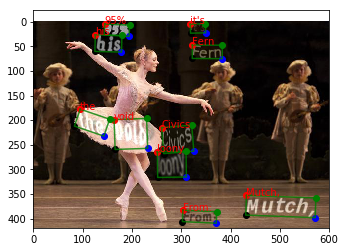

In [22]:
from PIL import Image
img = Image.open(SYNTH_HOME + imnames[0][0])
visualize_synthtext(np.array(img), wordBB[0], text[0])